Sales Forecasting
#2. Univariate modeling
## 2-5. Prophet

In [ ]:
import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import plotly.express as px

from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from prophet import Prophet
from prophet.plot import plot_yearly
from prophet.diagnostics import performance_metrics

In [ ]:
data_path = "/content/drive/MyDrive/github_repo/time-series-study/data"

In [ ]:
train = pd.read_csv(os.path.join(data_path, "train.csv"))
test = pd.read_csv(os.path.join(data_path, "test.csv"))

In [ ]:
def plot_by_family(df:pd.DataFrame, store_id:int, categories:list=[], return_data:bool=False):
  if len(categories) == 0:
    df = df.loc[df.store_nbr==store_id, ][["date", "family", "sales"]]
  else:
    df = df.loc[(df.store_nbr==store_id) & (df.family.isin(categories)), ][["date", "family", "sales"]]
  df = pd.pivot(df, index=["date"], columns = "family", values = "sales").reset_index()

  fig = px.line(df, x="date", y=df.columns,
                hover_data={"date": "|%B %d, %Y"},
                title='sales time series')
  fig.update_xaxes(
      dtick="M1",
      tickformat="%b\n%Y")
  fig.show()
  return df if return_data else None

In [ ]:
TARGET = "FROZEN FOODS" # ["LAWN AND GARDEN", "EGGS", "BEAUTY", "AUTOMOTIVE", "BOOKS", "FROZEN FOODS", "GROCERY I"]

In [ ]:
train_df = plot_by_family(train, 44, [TARGET], True)

## 1) Prophet

In [ ]:
valid_ratio = 0.7

In [ ]:
train_period = int(train_df.shape[0]*valid_ratio)
trains = train_df.iloc[:train_period].copy()
valids = train_df.iloc[train_period:].copy()

trains.rename(columns={"date":"ds", TARGET:"y"}, inplace=True)
valids.rename(columns={"date":"ds", TARGET:"y"}, inplace=True)

trains.shape, valids.shape

((1178, 2), (506, 2))

**파라미터 정보** \
(참고: https://velog.io/@choijhyeok/Prophet-1-parameter-%EC%95%8C%EC%95%84%EB%B3%B4%EA%B8%B0)

1) changepoint_prior_scale : 0.05 [default]
- 추세 조절 파라미터 (클수록 유연하게 반영)

추가적으로 기준일에 전날까지 반영할 거면 lower_window = -1, upper_window = 0
기준일에 다음날까지 반영하면 lower_window = 0, upper_window = 1

2) seasonality_prior_scale : 10 [default]
- 계절성 조절 파라미터 (클수록 계절성 영향 크게 반영), [0.01, 10]


3) holidays_prior_scale : 10.0 [default]
- 휴일 영향도 조절 파라미터 [0.01,10]

4) seasonality_mode : 'additive' [default] #'multiflicative'

5) changepoint_range : 0.8 [default]
- change point의 설정 가능 범위를 의미
- 0.8 이면 데이터의 80% 중 changepoint를 자동 설정 [0.8,0.95]

6) growth : linear [default] #'logistic'

7) changepoints : auto[default]
- 변경점을 수동으로 설정하기 위한 parameter

8) n_changepoints : 25 [default]
- 자동으로 배치된 변경점의 수
- 일반적인 시계열의 추세 변화를 파악하기 위해서 충분한 수로 설정해야 함

9) yearly_seasonality : auto [default]
- 데이터와 연간 계절성을 가지면 True 아니면 False로 설정
- Furier term 을 지정할 수 있음 (default: 10)
- weekly_seasonality,daily_seasonality 존재

10) holidays
- 지정된 공휴일의 데이터 프레임을 전달하기 위해서 사용
- 휴일 효과는 holidays_prior_scale을 통해서 조정

11) mcmc_samples : 0 [default]
- 계절성의 불확실성을 확인할 때 사용됨 기본적으로 Prophet은 추세 및 관찰 노이즈의 불확실성만을 반환함
- 계절성에 대한 불확실성을 얻으려면 전체 베이지안 샘플링을 수행해야 함

12) interval_width : 0.8 [default]
- 불확실성 구간

13) uncertainty_samples : 1000 [default]
- 불확실성의 구간을 조정함

In [ ]:
model = Prophet(seasonality_mode = 'additive',
                changepoint_prior_scale=0.001, # trend가 크지 않은 특성 반영하기 위해 작게 설정
                yearly_seasonality=30, # yearly 계절성은 강하게 반영
                weekly_seasonality=15, # weekly 계절성도 기본설정보다 강하게 반영
                daily_seasonality=10
                )
# model.add_seasonality(name='yearly', period=365, fourier_order=5)

In [ ]:
model.fit(trains)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4fpebvfm/z_e832a0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4fpebvfm/ono8skqz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67295', 'data', 'file=/tmp/tmp4fpebvfm/z_e832a0.json', 'init=/tmp/tmp4fpebvfm/ono8skqz.json', 'output', 'file=/tmp/tmp4fpebvfm/prophet_model3fqlrftl/prophet_model-20230611092615.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:26:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:26:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
preds = model.predict(valids)

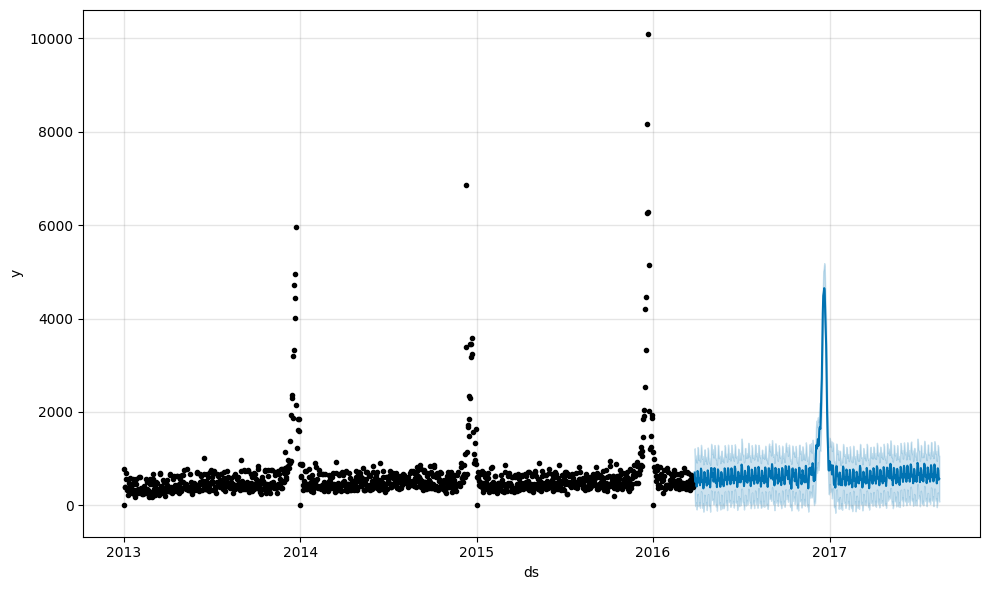

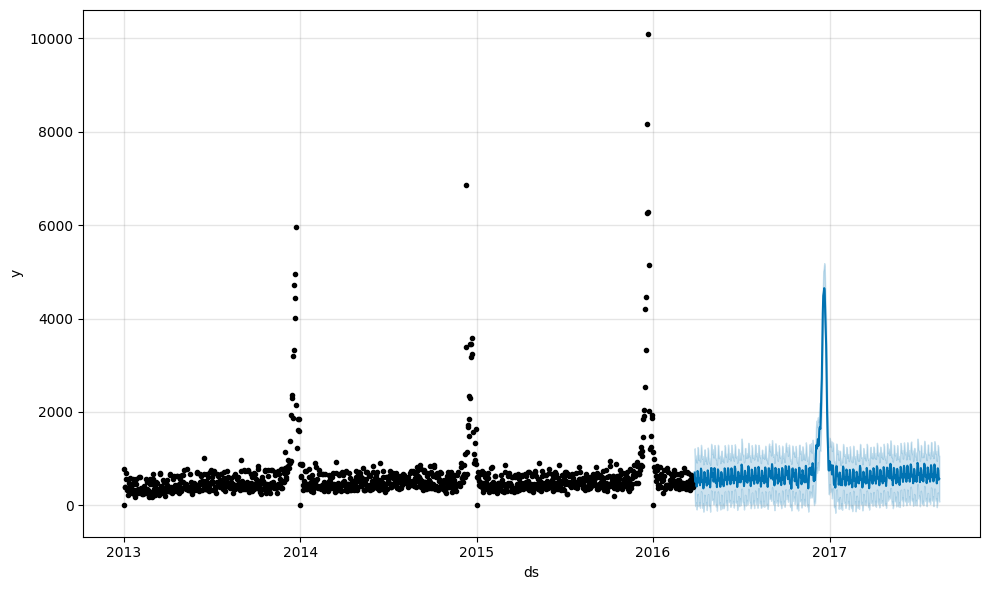

In [ ]:
model.plot(preds)

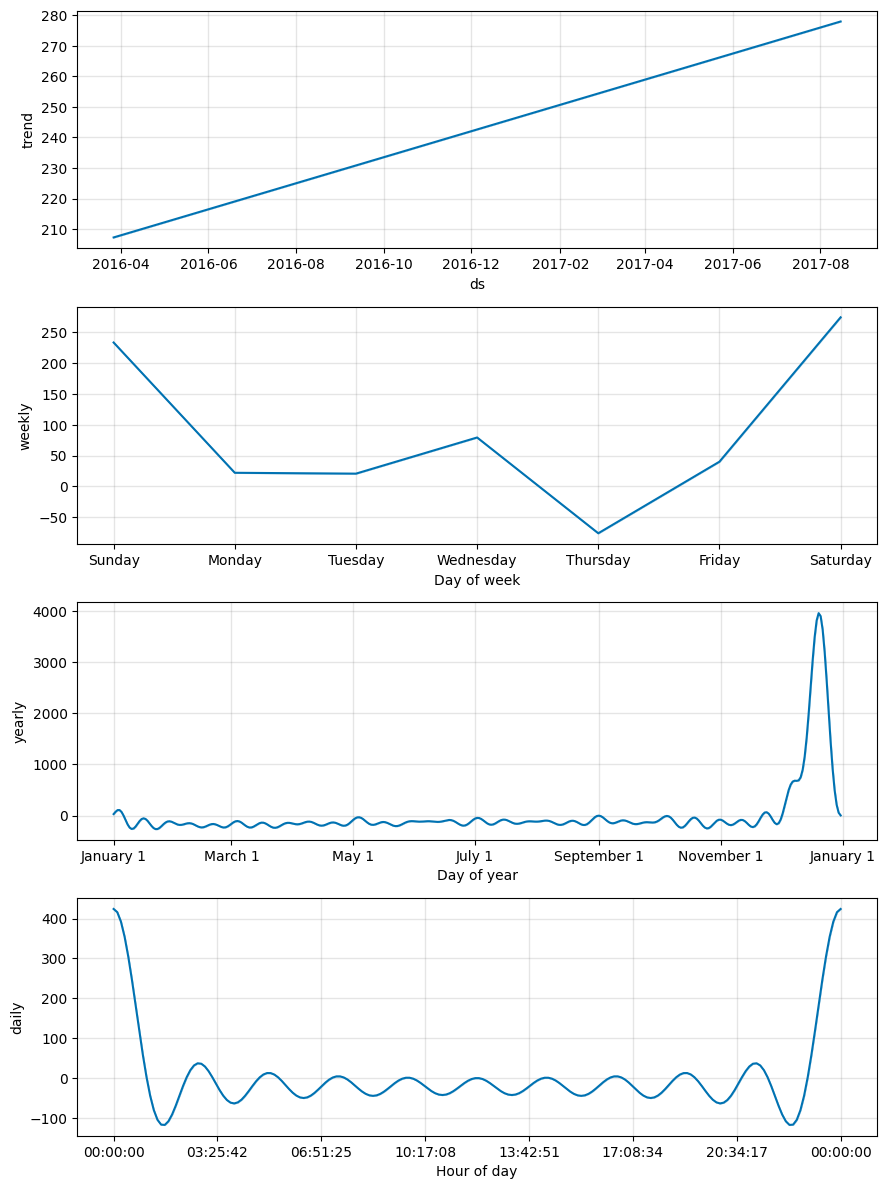

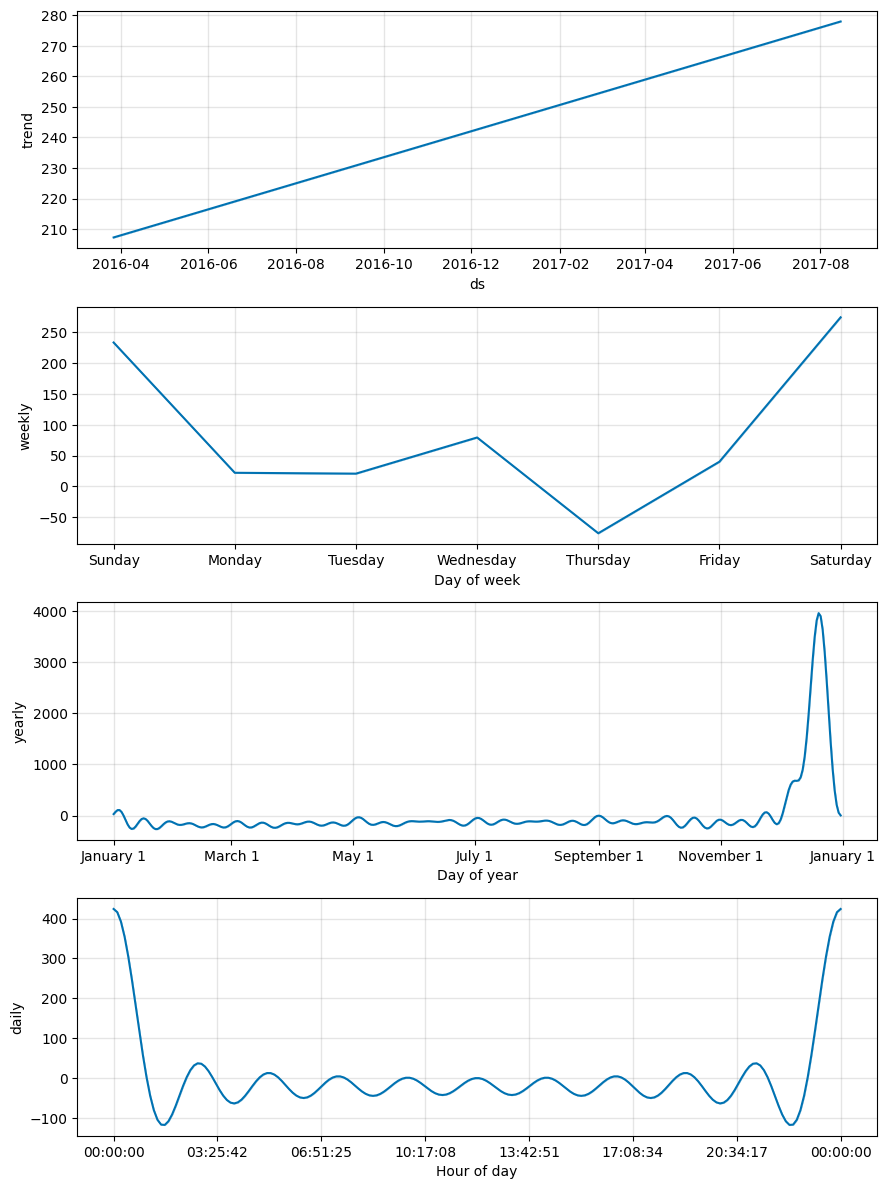

In [ ]:
model.plot_components(preds) #

In [ ]:
predictions = preds.yhat.copy()
predictions.index += valids.index.start

<Axes: >

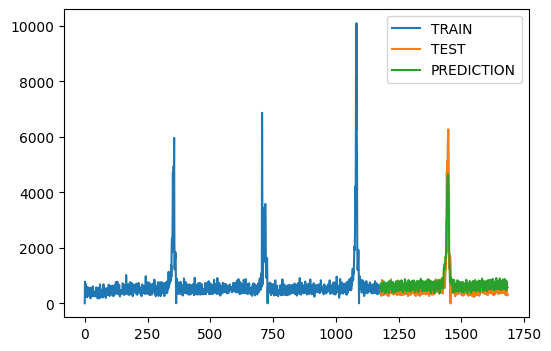

In [ ]:
train_df[TARGET].plot(legend=True, label='TRAIN')
valids['y'].plot(legend=True, label='TEST',figsize=(6,4))
predictions.plot(legend=True, label='PREDICTION')

<Axes: >

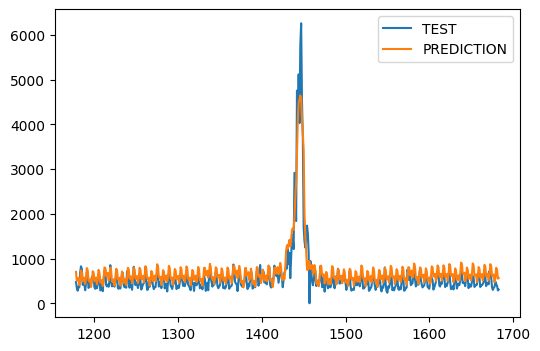

In [ ]:
valids['y'].plot(legend=True, label='TEST',figsize=(6,4))
predictions.plot(legend=True, label='PREDICTION')

In [ ]:
print(f'MAE = {mean_absolute_error(valids["y"], preds.yhat)}')
print(f'MSE = {mean_squared_error(valids["y"], preds.yhat)}')
print(f'RMSE = {np.sqrt(mean_squared_error(valids["y"], preds.yhat))}')

MAE = 171.40083058860102
MSE = 58915.00487848806
RMSE = 242.72413328403925
